In [1]:
import utils
import pandas as pd

In [2]:
log_dir_env1 = f"./pretrained_models/model1/env1/"
log_dir_env2 = f"./pretrained_models/model1/env2/"
log_dir_env3 = f"./pretrained_models/model1/env3/"

SWEET_SPOT = 0.30
BAD_SPOT = 0.30

## Observations about train and test dataset

### Train dataset
- The mean RUL for a machine in the train dataset is 225, and the maximum is 543.
- 25% of the episodes have the possibility to receive a reward higher than 258.

### Test dataset
- The mean RUL for a machine in the train dataset is 147, and the maximum is 485.

## Environment 1
- +1 for every timestep
- -dataframe['rul'].max() if the machine crashes

In [3]:
# Load result dataframe
df_env1 = pd.read_csv(f'{log_dir_env1}results.csv')

### Reward

#### Reward during training

Observations:
- The reward during training is rarely negative. 
- From the graph we can observe that the training never goes above 300 actions (reward = num actions, since only +1 per action), but in fact 88/709=12.4% have a max RUL above 300 and thereby have the possibility to take more than 300 actions.
- It can be observed that during training the agent rarely takes more than 200 actions, and does not come close to the maximum reward for the episodes with highest RUL.

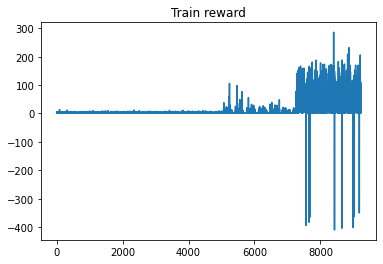

In [4]:
stop = 600
# Reward plot
utils.plot_train_reward(log_dir_env1)

#### Reward during testing

Observations:
- The same tendensis as for training can be observed during testing. The agent does not try for a high amount of actions, and if it does it seems like it crashes.

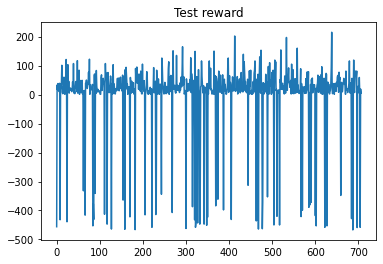

In [5]:
utils.plot_test_reward(df_env1)

##### Normalized reward during testing
- Have plotted reward/max RUL for the episode in order to observe how large percentage of the possible reward for each episode the agent achieves. The optimal score is 1.
- All negative reward (if the machine crashes) have been set to zero. These points are marked with a red spot.
- All perfectly stopped machines (with normalized reward = 1) are marked with green dots.

Observation:

- We see that on average the machines only achieves 24% of the possible reward, which is low.

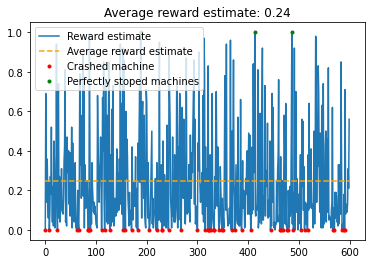

In [6]:
# Plot average reward
utils.plot_average_reward(df_env1, stop=stop)

### Average slack during testing
- Slack is the difference between possible number of actions and number of actions taken.
- The slack is normalized by dividing by the possible number of actions.
- Optimally the slack is 0.

Observations:
- The average slack is quite high, 67% of possible number of actions.
- On average the agent stops within the first 33% of the possible number of actions -> much potential for increasing the reward.

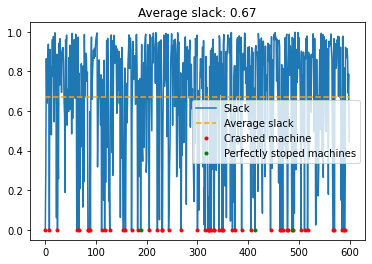

In [7]:
# Slack
a1 = utils.plot_slack(df_env1, stop=stop)

### Maximum RUL for the machines that crashes
- Average max_RUL for the crashed machines is 68.2 (whereas the average max_RUL for all machines is 147)
    - Low max RUL leads to higher chance for crashing. This might imply that the agent does not learn from the sensor data, but learns a pattern for the average number of actions it can safely complete before the machine crashes.

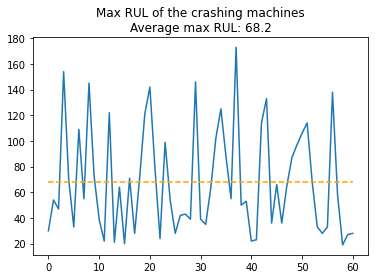

In [8]:
# Plot the max RUL for the crashing machines
utils.plot_crash_points_max_rul(df_env1)

### Further observation during testing
- Few crashed machines, but this is probably caused by the agent "playing it safely".

- Only 3.7% of the machines with higher RUL than average run for more cycles than the average max_RUL (147)
    - The ones who does, only go a little bit above
    
- 423/707 = 59.8% of the machines stops within the badspot (the first 30% of their possible number of cycles). 

- Does our agent play it too safe? Does it prefer lower reward and lower risk over high reward and high risk? 

In [9]:
b1, c1, d1 = utils.environment_results(df_env1)

percent_of_crashed_machines: 0.0863
percent_of_perfect_machines: 0.0042
stop_within_sweetspot: 0.0622


In [10]:
# It almost doesn't dare going above the mean. The only cases:
e1 = len(df_env1[df_env1['num_actions'] > df_env1['max_RUL'].mean()])
f1 = e1 / len(df_env1[df_env1['max_RUL'] > df_env1['max_RUL'].mean()])
print('Number of episodes that takes num actions above the mean:\n', e1)
print('Percentage of episodes with numb actions above mean / numb episodes with RUL above mean: \n', f1)
df_env1[df_env1['num_actions'] > df_env1['max_RUL'].mean()]

Number of episodes that takes num actions above the mean:
 12
Percentage of episodes with numb actions above mean / numb episodes with RUL above mean: 
 0.037267080745341616


,Unnamed: 0,machine,reward,num_actions,max_RUL,slack,reward_estimate
62,62,63,-332,154,154,0,0.00
270,270,271,151,151,242,91,0.62
292,292,293,165,165,244,79,0.68
321,321,322,149,149,179,30,0.83
365,365,366,150,150,157,7,0.96
413,413,414,202,202,202,0,1.00
444,444,445,-313,173,173,0,0.00
474,474,475,153,153,239,86,0.64
520,520,521,154,154,239,85,0.64
533,533,534,197,197,202,5,0.98


In [11]:
g1 = len(df_env1[df_env1['num_actions'] < (BAD_SPOT * df_env1['max_RUL'])])
print(f'Number of episodes stopping within the {BAD_SPOT}% of the episodes max RUL: ', g1)
df_env1[df_env1['num_actions'] < (BAD_SPOT * df_env1['max_RUL'])]

Number of episodes stopping within the 0.3% of the episodes max RUL:  423


,Unnamed: 0,machine,reward,num_actions,max_RUL,slack,reward_estimate
2,2,3,17,17,125,108,0.14
5,5,6,15,15,104,89,0.14
6,6,7,10,10,159,149,0.06
7,7,8,39,39,165,126,0.24
9,9,10,17,17,191,174,0.09
...,...,...,...,...,...,...,...
700,700,701,30,30,111,81,0.27
701,701,702,6,6,198,192,0.03
703,703,704,4,4,62,58,0.06
705,705,706,19,19,93,74,0.20


In [12]:
env1_values = [a1, b1, c1, d1, e1, f1, g1]

## Environment 2
- +1 for every timestep

We tried to decrease the slack by changing the rewards:
- +100 if the machine stops within the sweetspot(last 30% of the max possible actions).
- dataframe['rul'].max()*-1.5 if the machine crashes. We increase penalty to compansate for more possible reward.

In [13]:
df_env2 = pd.read_csv(f'{log_dir_env2}results.csv')

stop = 200

### Reward

- Observe that the reward during training and testing has the same tendencies as in **env1**, but a bit higher/lower general rewards due to the new rewards. 

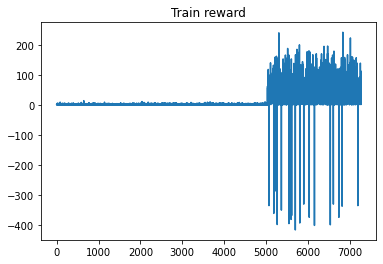

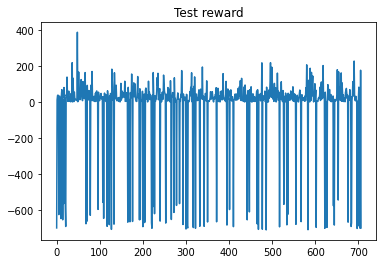

In [14]:
# Reward
utils.plot_train_reward(log_dir_env2)
utils.plot_test_reward(df_env2)

- The average normalized reward is lower because we increased the possible reward if the agent stops the machine within the sweetspot. Most of the machines does not reach the sweetspot, and thereby their normalized reward is decreased. 

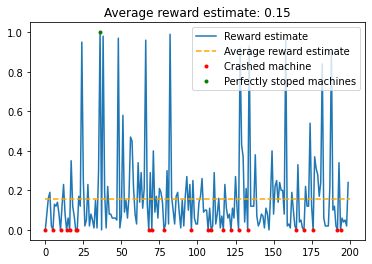

In [15]:
# Plot average reward
utils.plot_average_reward(df_env2, stop=stop, extra_reward=100)

### Slack
- The main goal of this new environment was to decrease the slack. The slack was only reduced by 1%, which may a coincidence.
    - Our attempt failed 🥲😔

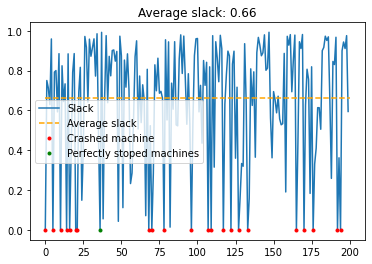

In [16]:
# Slack
a2 = utils.plot_slack(df_env2, stop=stop)

### Max RUL for the machines that crashes

- The max RUL for the crashed machines have the same tendencies as **env1**

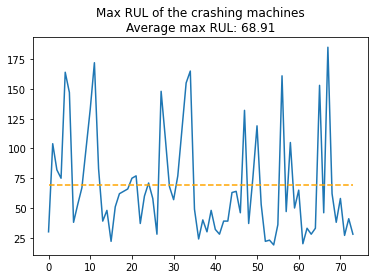

In [17]:
# Plot the max RUL for the crashing machines
utils.plot_crash_points_max_rul(df_env2)

### Further observation during testing

**Env1**:
- percent_of_crashed_machines: 0.0863
- percent_of_perfect_machines: 0.0042
- stop_within_sweetspot: 0.0622

Very small differences. Might be coincidental.

In [18]:
b2, c2, d2 = utils.environment_results(df_env2)

percent_of_crashed_machines: 0.1047
percent_of_perfect_machines: 0.0028
stop_within_sweetspot: 0.0495


In [19]:
# It almost doesn't dare going above the mean. The only cases:
e2 = len(df_env2[df_env2['num_actions'] > df_env2['max_RUL'].mean()])
f2 = e2 / len(df_env2[df_env2['max_RUL'] > df_env2['max_RUL'].mean()])
print('Number of episodes that takes num actions above the mean:\n', e2)
print('Percentage of episodes with numb actions above mean / numb episodes with RUL above mean: \n', f2)
df_env2[df_env2['num_actions'] > df_env2['max_RUL'].mean()]

Number of episodes that takes num actions above the mean:
 16
Percentage of episodes with numb actions above mean / numb episodes with RUL above mean: 
 0.049689440993788817


,Unnamed: 0,machine,reward,num_actions,max_RUL,slack,reward_estimate
16,16,17,-565,164,164,0,0.00
48,48,49,388,289,302,13,0.97
51,51,52,167,167,188,21,0.58
107,107,108,-557,172,172,0,0.00
174,174,175,156,156,191,35,0.54
223,223,224,-581,148,148,0,0.00
278,278,279,-574,155,155,0,0.00
285,285,286,-564,165,165,0,0.00
476,476,477,218,218,246,28,0.63
499,499,500,194,194,413,219,0.38


In [20]:
g2 = len(df_env2[df_env2['num_actions'] < (BAD_SPOT * df_env2['max_RUL'])])
print(f'Number of episodes stopping within the {BAD_SPOT}% of the episodes max RUL: ', g2)
df_env2[df_env2['num_actions'] < (BAD_SPOT * df_env2['max_RUL'])]

Number of episodes stopping within the 0.3% of the episodes max RUL:  413


,Unnamed: 0,machine,reward,num_actions,max_RUL,slack,reward_estimate
1,1,2,12,12,48,36,0.08
2,2,3,36,36,125,89,0.16
4,4,5,4,4,97,93,0.02
6,6,7,33,33,159,126,0.13
7,7,8,33,33,165,132,0.12
...,...,...,...,...,...,...,...
698,698,699,3,3,203,200,0.01
700,700,701,29,29,111,82,0.14
702,702,703,11,11,183,172,0.04
703,703,704,13,13,62,49,0.08


In [21]:
env2_values = [a2, b2, c2, d2, e2, f2, g2]


## Environment 3
- +1 for every timestep

New attempt to decrease the slack. We introduced a "bad spot", in an attempt to avoid the agent from stopping the machines too early. 
- +200 if stopped within sweetspot
- -200 if stopped within bad spot
- -dataframe['rul'].max() if the machine crashes

In [ ]:
df_env3 = pd.read_csv(f'{log_dir_env3}results.csv')

stop = 200

### Reward

- Observe that the reward during training and testing has the same tendencies as in env1, but a bit higher/lower general rewards due to the new rewards.

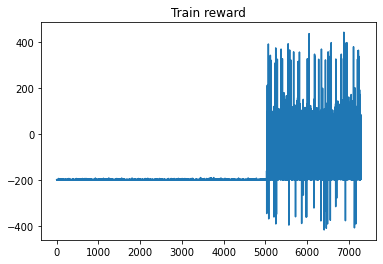

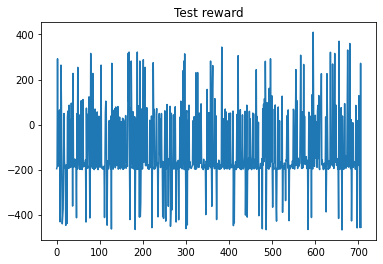

In [23]:
# Reward
utils.plot_train_reward(log_dir_env3)
utils.plot_test_reward(df_env3)

#### Normalized reward
- The average normalized reward is lower because we increased the possible reward if the agent stops the machine within the sweetspot and penalized if the agent stops the machine within the bad spot.


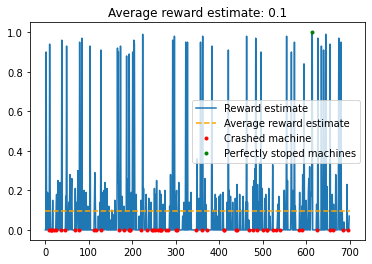

In [24]:
# Plot average reward
utils.plot_average_reward(df_env3, stop=700, extra_reward=200)

- Only 10% of the episodes have above 0.2 as normalized reward

In [25]:
df_env3.describe(percentiles= [.75,.90,.95])

,Unnamed: 0,machine,reward,num_actions,max_RUL,slack,reward_estimate
count,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000
mean,353.000000,354.000000,-115.222065,35.974540,147.369165,111.394625,0.096110
std,204.237607,204.237607,165.532903,32.946079,78.471162,82.642776,0.226027
min,0.000000,1.000000,-468.000000,1.000000,18.000000,0.000000,0.000000
50%,353.000000,354.000000,-178.000000,26.000000,141.000000,105.000000,0.000000
75%,529.500000,530.500000,32.000000,51.000000,186.000000,155.000000,0.110000
90%,635.400000,636.400000,86.000000,81.000000,246.400000,215.000000,0.230000
95%,670.700000,671.700000,236.600000,106.000000,287.700000,266.100000,0.900000
max,706.000000,707.000000,410.000000,211.000000,485.000000,429.000000,1.000000


### Slack
- The slack is actually higher now, but only by 2%, which might be coincidental.
    - Our attempt failed 🥲😔

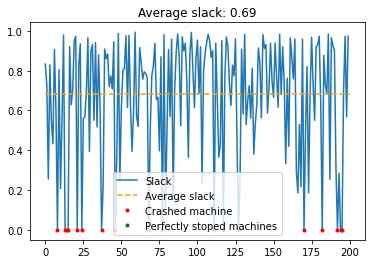

In [26]:
# Slack
a3 = utils.plot_slack(df_env3, stop=stop)

### Max RUL for the machines that crashes
- The max RUL for the crashed machines have the same tendencies as **env1**

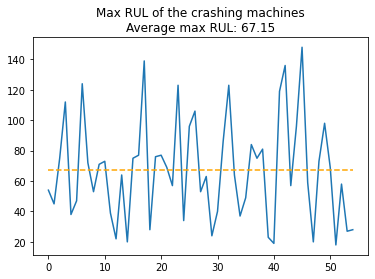

In [27]:
# Plot the max RUL for the crashing machines
utils.plot_crash_points_max_rul(df_env3)

### Further observation during testing

Env1:
- percent_of_crashed_machines: 0.0863
- percent_of_perfect_machines: 0.0042
- stop_within_sweetspot: 0.0622

Env3:
- Small diffrences, and we have fewer perfect machines and fewer within sweetspot.

In [28]:
b3, c3, d3 = utils.environment_results(df_env3)

percent_of_crashed_machines: 0.0778
percent_of_perfect_machines: 0.0014
stop_within_sweetspot: 0.0509


- Lower amount of actions above mean (env1: 16, env2. 12, env3: 7)

In [29]:
# It almost doesn't dare going above the mean. The only cases:
e3 = len(df_env3[df_env3['num_actions'] > df_env3['max_RUL'].mean()])
f3 = e3 / len(df_env3[df_env3['max_RUL'] > df_env3['max_RUL'].mean()])
print('Number of episodes that takes num actions above the mean:\n', e3)
print('Percentage of episodes with numb actions above mean / numb episodes with RUL above mean: \n', f3)
df_env3[df_env3['num_actions'] > df_env3['max_RUL'].mean()]

Number of episodes that takes num actions above the mean:
 7
Percentage of episodes with numb actions above mean / numb episodes with RUL above mean: 
 0.021739130434782608


,Unnamed: 0,machine,reward,num_actions,max_RUL,slack,reward_estimate
349,349,350,156,156,233,77,0.36
361,361,362,158,158,233,75,0.36
493,493,494,161,161,277,116,0.34
531,531,532,-338,148,148,0,0.00
595,595,596,410,211,290,79,0.84
655,655,656,370,171,195,24,0.94
680,680,681,360,161,177,16,0.95


In [30]:
g3 = len(df_env3[df_env3['num_actions'] < (BAD_SPOT * df_env3['max_RUL'])])
print(f'Number of episodes stopping within the {BAD_SPOT}% of the episodes max RUL: ', g3)
df_env3[df_env3['num_actions'] < (BAD_SPOT * df_env3['max_RUL'])]

Number of episodes stopping within the 0.3% of the episodes max RUL:  435


,Unnamed: 0,machine,reward,num_actions,max_RUL,slack,reward_estimate
0,0,1,-196,5,30,25,0.0
1,1,2,-188,13,48,35,0.0
3,3,4,-183,18,105,87,0.0
6,6,7,-186,15,159,144,0.0
9,9,10,-164,37,191,154,0.0
...,...,...,...,...,...,...,...
698,698,699,-181,20,203,183,0.0
700,700,701,-181,20,111,91,0.0
702,702,703,-168,33,183,150,0.0
703,703,704,-193,8,62,54,0.0


In [31]:
env3_values = [a3, b3, c3, d3, e3, f3, g3]

## Summary

- It seems like the DQN agent does not explore high enough number of actions during training. 
- May prefer low reward and low risk, than high reward and high risk.
- During testing the agent normally stops the machine before reaching the average RUL for all machines. And on average stops the machine on the first 30 % of the possible number of actions for the episodes.
- Changing the reward function has little to no impact on these observations.
- Maybe the agent does not see any patterns in the sensor data? Rather finds a safe general number of actions to execute.

## Trying a new agent: PPO
- Exchange the DQN-agent with a PPO-agent
- Continue using **env3**
    - +200 if stop within sweetspot
    - -200 if stop within bad spot
    - -dataframe['rul'].max() if crash machine

In [32]:
log_dir_new_model = f"./pretrained_models/model2/env3/"

# Load result dataframe
df_new_model = pd.read_csv(f'{log_dir_new_model}results.csv')

### Reward

#### Train reward

Observations:
- Very different than prior experiments. More episodes with reward above 400 -> It explores more during training.

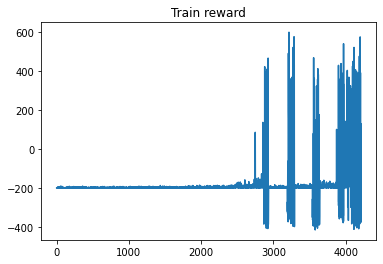

In [33]:
stop = 300
# Reward
utils.plot_train_reward(log_dir_new_model)

#### Test reward
Observations:
- More negative reward than for the DQN-agent with env3.
- Also achieves some higher rewards.

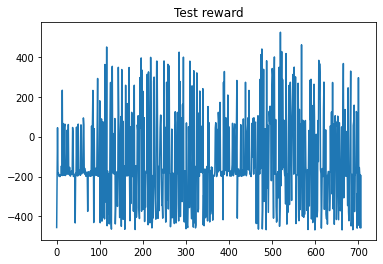

In [43]:
utils.plot_test_reward(df_new_model)

#### Average reward during testing
- A bit higher average than for **env3**

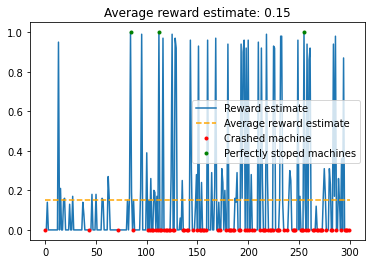

In [44]:
# Plot average reward
utils.plot_average_reward(df_new_model, stop=stop, extra_reward=200)

### Average slack during testing

Observations:
- The average slack is lower!
- On average the machine stops within the first 52% of the possible number of actions

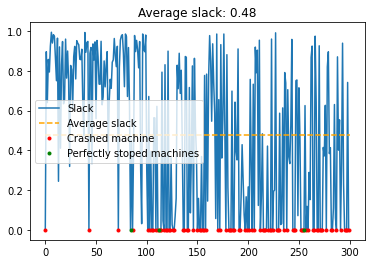

In [36]:
# Slack
a4 = utils.plot_slack(df_new_model, stop=stop)

### Max RUL for the machines that crashes
- Average max_RUL for crashing machines are higher than the DQN-agent.
- Now it's not only the machines with low RUL that crashes. The highest max_RUL for crashing machine is now approx. 300, before it was approx. 150. 
    

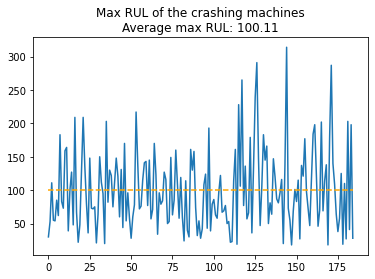

In [37]:
# Plot the max RUL for the crashing machines
utils.plot_crash_points_max_rul(df_new_model)

#### Further observation during testing
- A lot more machines crashes
- A bit more stop within sweetspot
- The agent clearly takes more risk to get a higher reward

In [38]:
b4, c4, d4 = utils.environment_results(df_new_model)

percent_of_crashed_machines: 0.2617
percent_of_perfect_machines: 0.0042
stop_within_sweetspot: 0.0679


- 24% of the machines run for more cycles than the average max_RUL (147) which is much higer than the previous 3.7%. 
- But there are also more machines that crash

In [45]:
# It almost doesn't dare going above the mean. The only cases:
e4 = len(df_new_model[df_new_model['num_actions'] > df_new_model['max_RUL'].mean()])
f4 = e4 / len(df_new_model[df_new_model['max_RUL'] > df_new_model['max_RUL'].mean()])
print('Number of episodes that takes num actions above the mean:\n', e4)
print('Percentage of episodes with numb actions above mean / numb episodes with RUL above mean: \n', f4)
df_new_model[df_new_model['num_actions'] > df_new_model['max_RUL'].mean()]

Number of episodes that takes num actions above the mean:
 79
Percentage of episodes with numb actions above mean / numb episodes with RUL above mean: 
 0.2453416149068323


,Unnamed: 0,machine,reward,num_actions,max_RUL,slack,reward_estimate
100,100,101,180,180,257,77,0.39
106,106,107,-303,183,183,0,0.00
112,112,113,362,163,163,0,1.00
113,113,114,-327,159,159,0,0.00
114,114,115,-322,164,164,0,0.00
...,...,...,...,...,...,...,...
666,666,667,-307,179,179,0,0.00
671,671,672,-199,287,287,0,0.00
690,690,691,158,158,369,211,0.28
698,698,699,-283,203,203,0,0.00


#### Number of machines stopping within the badspot
- 278/707 = 39% of the machines stops within the first 30% of their possible number of cycles. Which is much lower than the previous 59.8%.

In [47]:
g4 = len(df_new_model[df_new_model['num_actions'] < (BAD_SPOT * df_new_model['max_RUL'])])
print(f'Number of episodes stopping within the {BAD_SPOT}% of the episodes max RUL: ', g4)
df_new_model[df_new_model['num_actions'] < (BAD_SPOT * df_new_model['max_RUL'])]

Number of episodes stopping within the 0.3% of the episodes max RUL:  278


,Unnamed: 0,machine,reward,num_actions,max_RUL,slack,reward_estimate
1,1,2,-196,5,48,43,0.0
3,3,4,-186,15,105,90,0.0
4,4,5,-181,20,97,77,0.0
5,5,6,-193,8,104,96,0.0
6,6,7,-200,1,159,158,0.0
...,...,...,...,...,...,...,...
694,694,695,-179,22,175,153,0.0
702,702,703,-155,46,183,137,0.0
703,703,704,-188,13,62,49,0.0
705,705,706,-193,8,93,85,0.0


In [48]:
new_model_values = [a4, b4, c4, d4, e4, f4, g4]

## Table to compare results

- Changing the environment had little effect on the overall results.
- But changing the agent from DQN to PPO had much more impact: More machines crashed, but also more machines with higher reward and lower slack.
    - It can be concluded that the PPO takes much more risk to get higher reward than the DQN 

##### Conclusion:
- None of these agents or environments solve the assignment with a sufficent result.


In [49]:
all_rows = [env1_values, env2_values, env3_values, new_model_values]
df = pd.DataFrame(all_rows, columns=['avrg_slac', '%crashed', '%perfect', '%sweetspot', 'above_mean', '%above-mean', 'bad_spot'])
df

,avrg_slac,%crashed,%perfect,%sweetspot,above_mean,%above-mean,bad_spot
0,0.668742,0.0863,0.0042,0.0622,12,0.037267,423
1,0.664257,0.1047,0.0028,0.0495,16,0.049689,413
2,0.685160,0.0778,0.0014,0.0509,7,0.021739,435
3,0.475157,0.2617,0.0042,0.0679,79,0.245342,278
